1.6.04.28

# 1. Introduction 

A brief description of your approach to the problem and the results that you have obtained on the training data.

<font color="red"><b>!!!!!!!! FILL THIS IN PLS<b>

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such a way that I can modify it to run on my own machine by simply changing the location of the training data and any additional data sources that you have used.


### 2.1 Import the libraries

In [59]:
# The dependencies for anaconda can be downloaded from the main directory.
# There are some version control works have to be done for the incompatibility
# e.g. 'pandas_ml does not work with pandas >= 0.25.0, so we used the pandas = 0.24.2'
import numpy as np
import pandas as pd
import pandas_profiling
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
#from pandas_ml import ConfusionMatrix

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)
%matplotlib inline

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

### 2.2 Load the datasets

In [2]:
df_train = pd.read_csv("DataFiles/CreditCard_train.csv",header = 1)
df_test = pd.read_csv("DataFiles/CreditCard_test.csv",header = 1)

In [3]:
all_data = pd.concat([df_train,df_test])
all_data.reset_index(inplace = True)
# all_data.set_index('ID')
# all_data.index = range(len(all_data.index))

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
index                         30000 non-null int64
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5               

### 2.3 Data dictionary
Below is a data dictionary from https://www.kaggle.com/yapsoonchung/eda-on-default-of-credit-card-clients-dataset/comments & https://www.researchgate.net/publication/326171439_Default_Payment_Analysis_of_Credit_Card_Clients

# 3. Data Transformation & EDA
any exploration of the data that you performed such as visualization, feature extraction, etc.

### 3.1 Data Transformation

In [5]:
# check for unique values in each columns
for c in all_data.columns[2:11]:
    unique_vals = all_data[c].unique()
    print(c,"-"*5,unique_vals)

LIMIT_BAL ----- [  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]
SEX ----- [2 1]
EDUCATION ----- [2 1 3 5 4 6 0]
MARRIAGE ----- [1 2 3 0]
AGE ----- [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
PAY_0 ----- [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2 ----- [ 2  0 -1 -2

Issues found:
1. SEX: The encoding should be changed to 0(female) and 1(male)
2. EDUCATION: Merge the label [0,5,6] with 4(others)
3. MARRIAGE: Merge the label [0] with 3(others)
4. PAY_0: Rename to PAY_1

In [6]:
def transform(data):
    
    #rename the feature PAY_0 to keep the names consistent
    data = data.rename(columns={"PAY_0": "PAY_1"}) 
    
    #0:female,1:male
    sex = {2:0} 
    data["SEX"] = data["SEX"].replace(sex)
    
    #recatergorize unknown labels
    data["EDUCATION"].replace([0,5,6], 4, inplace = True)
    data["MARRIAGE"].replace([0], 3, inplace = True)
    
    #drop ID, as this information does not help predicting the default value
    data.drop('ID', axis = 1,inplace = True)
    data.drop('index', axis = 1,inplace = True)
    
    return data

In [7]:
all_data = transform(all_data)

### 3.2 Data Exploration (EDA)

1. Use auto-generated report to get an overview of the data
2. Use boxplots to visualize outliners in numerial features
3. Use describe() to retrive the gereral statistics for each feature
4. Use countplot() to visualise the distribution of all the categorical features
5. Explore sum of pay status
6. Explore limit - bill
7. Explore Bill - Paid
8. Evaluate the skewness of the distribution

#### 3.2.1 Auto-generated report

In [8]:
# check data types, features, null values
pandas_profiling.ProfileReport(all_data)

/Users/shunshao/opt/anaconda3/envs/cw/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,24
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,5.5 MiB
Average record size in memory,192.0 B
Numeric,17
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


#### 3.2.2 use boxplots to evaluate the skewness of and visualize outliners

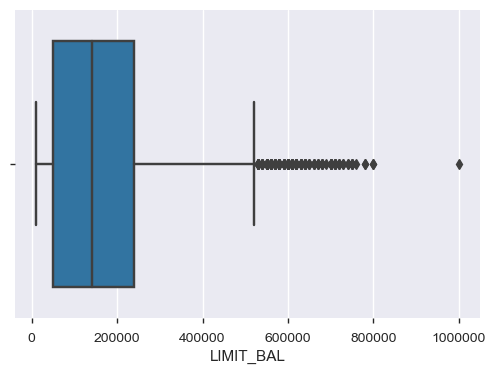

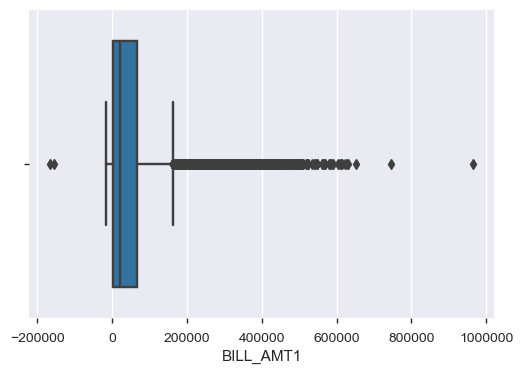

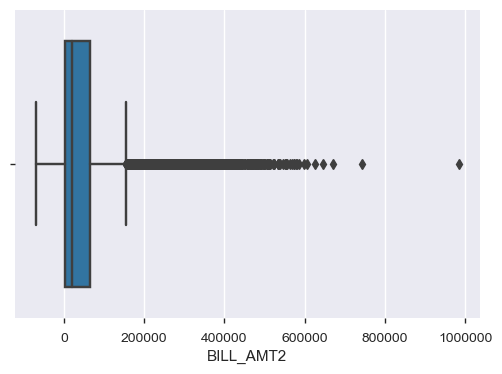

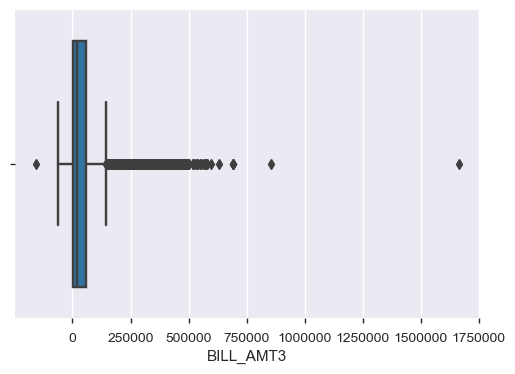

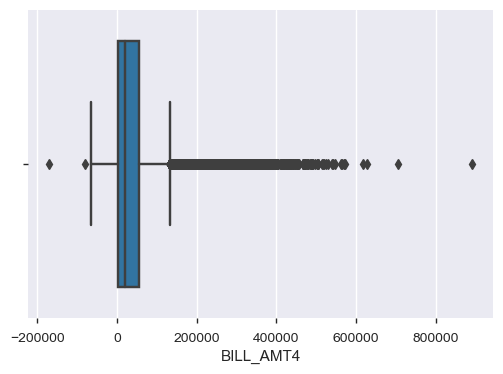

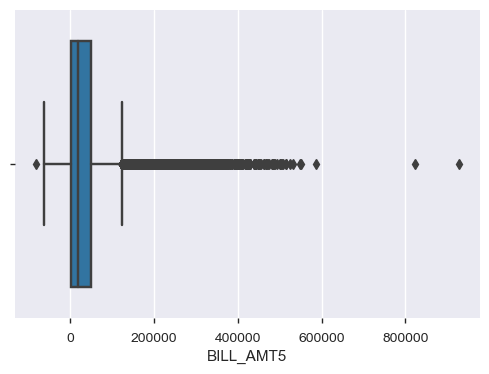

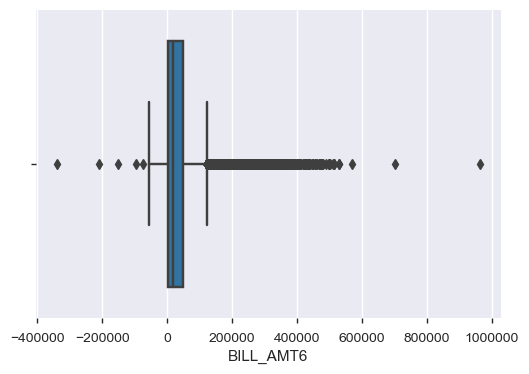

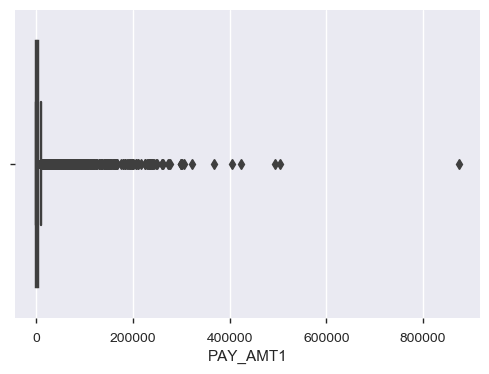

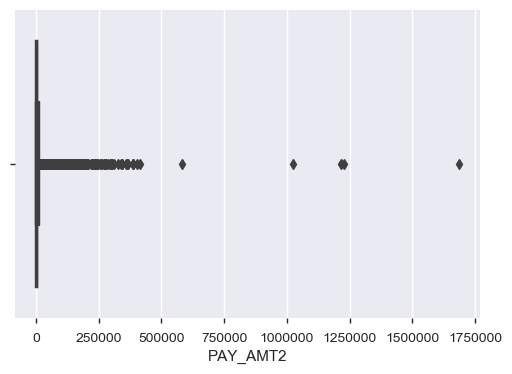

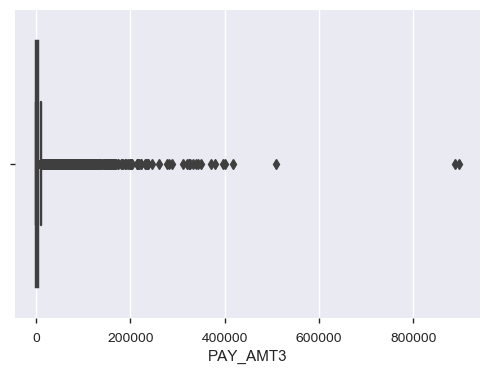

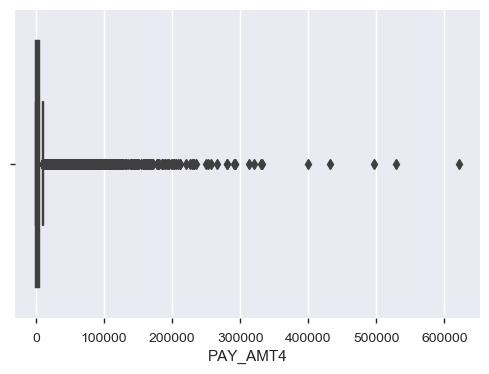

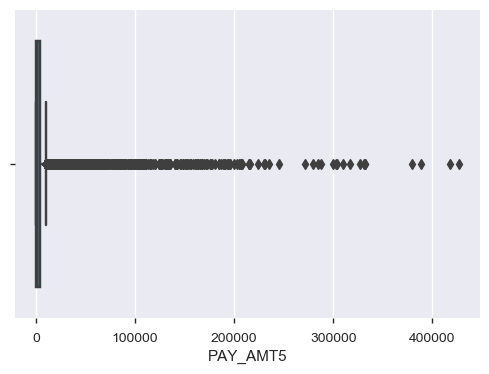

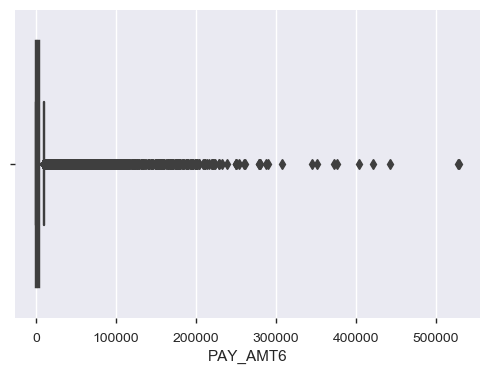

In [9]:
for c in ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.boxplot(x=all_data[c])
    plt.show()

#### 3.2.3 Use describe( ) to retrive the gereral statistics for each feature

In [10]:
all_data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,0.396267,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,1.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,1.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
#we divided the statistics into 4 catergories incase we need to use these statistics later in feature engineering
general_stats= all_data.describe().iloc[:,:5]
pay_status_stats = all_data.describe().iloc[:,5:11]
bill_stats = all_data.describe().iloc[:,11:17]
payed_stats = all_data.describe().iloc[:,17:23]

# save the Q1 and Q3 in separate dataframe
Q1 = pd.concat([general_stats.loc["25%"],bill_stats.loc["25%"],payed_stats.loc["25%"]])
Q3 = pd.concat([general_stats.loc["75%"],bill_stats.loc["75%"],payed_stats.loc["75%"]])

In [12]:
# all_data.iplot()

#### 3.2.4 use countplot( ) to visualise the distribution of all the categorical features and the distribution of "default of next month"

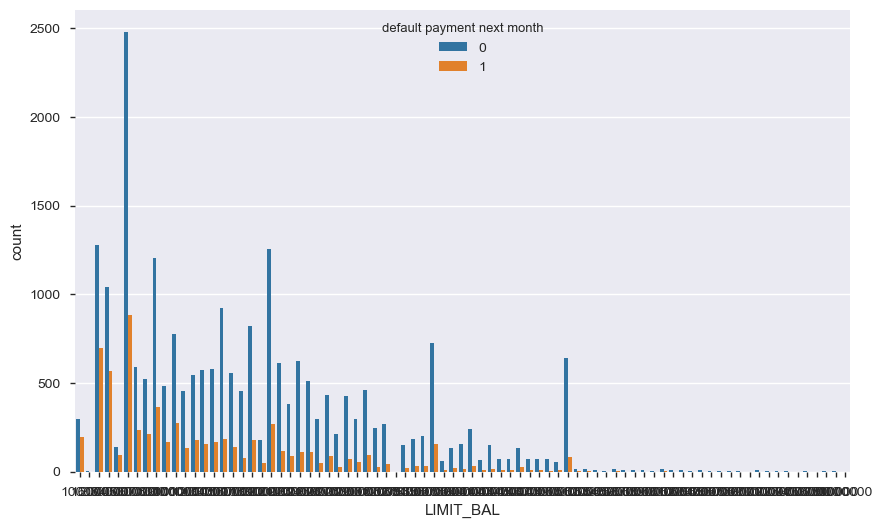

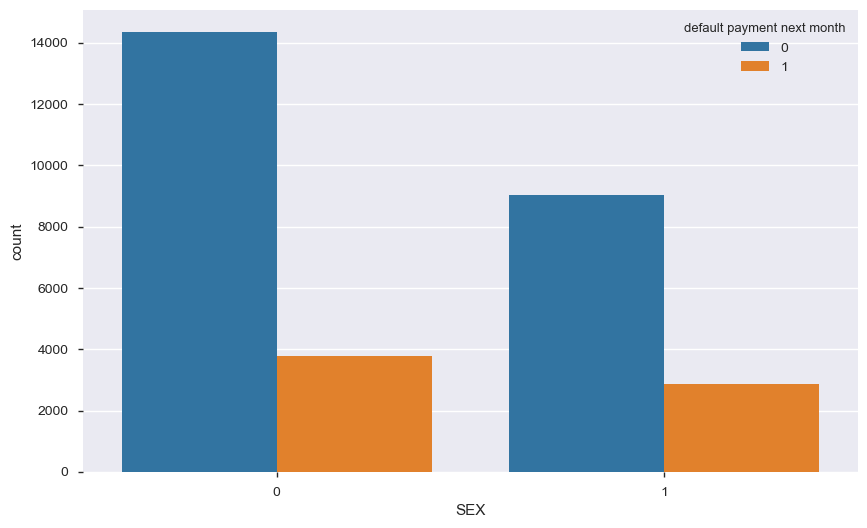

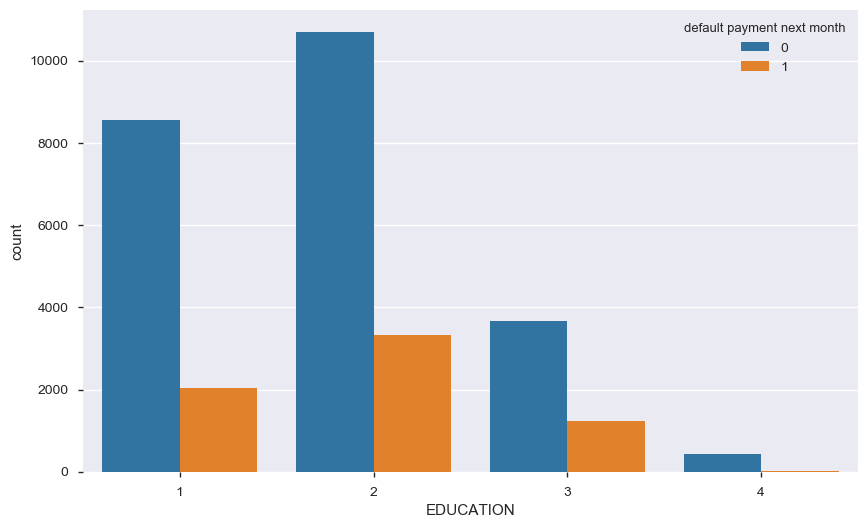

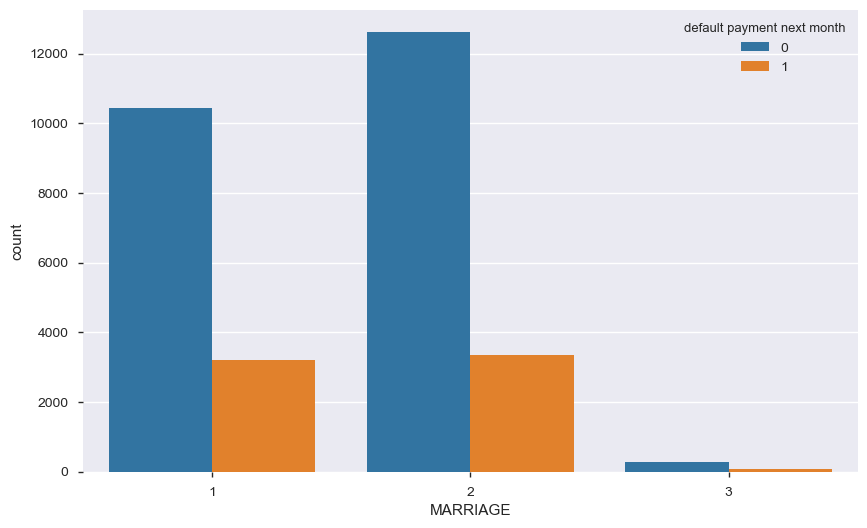

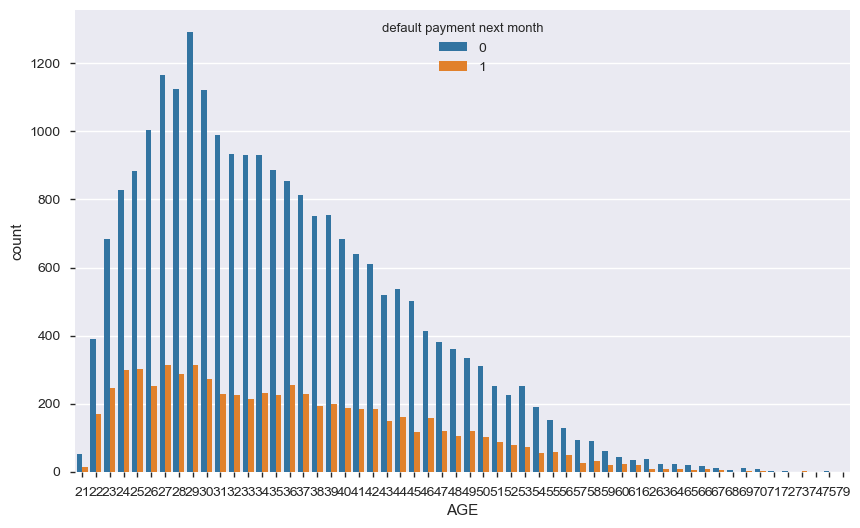

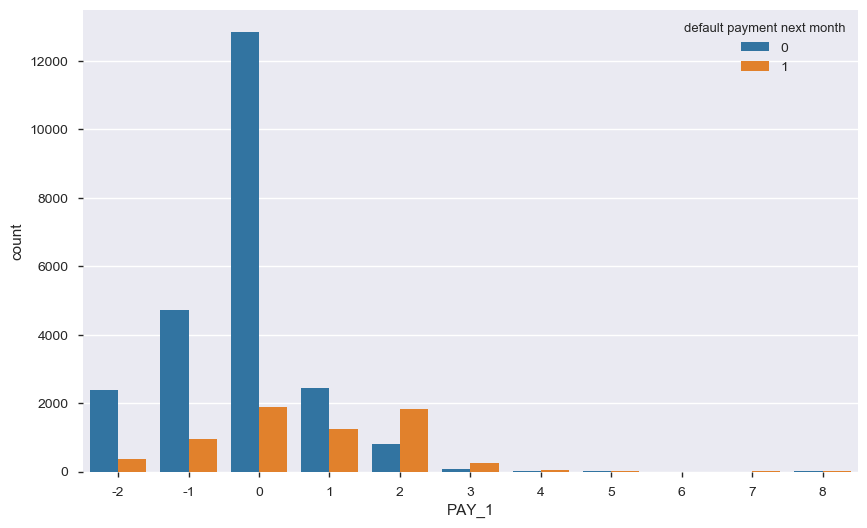

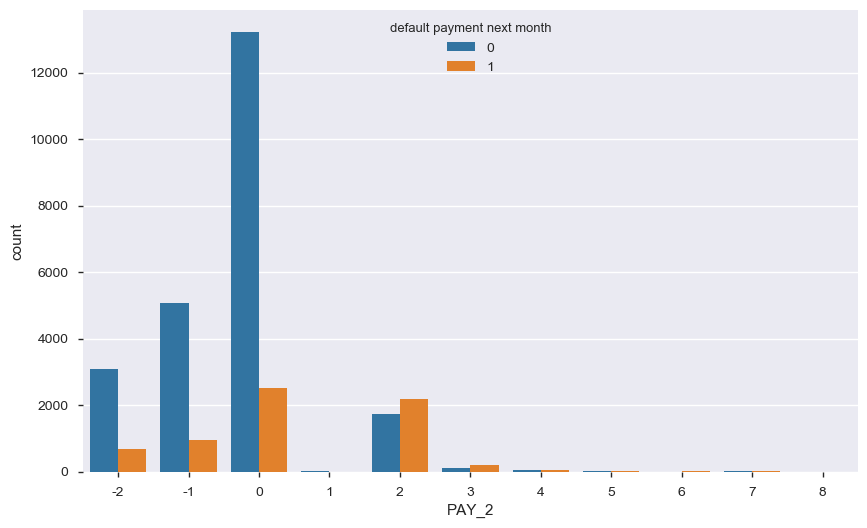

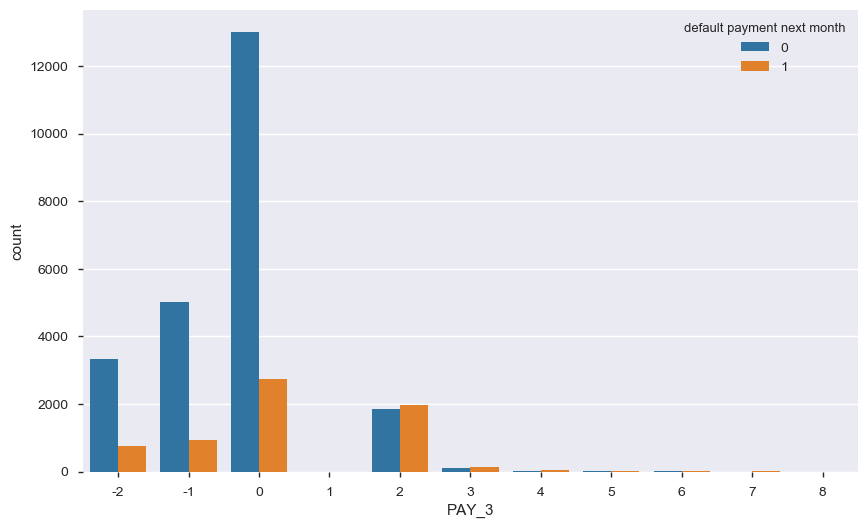

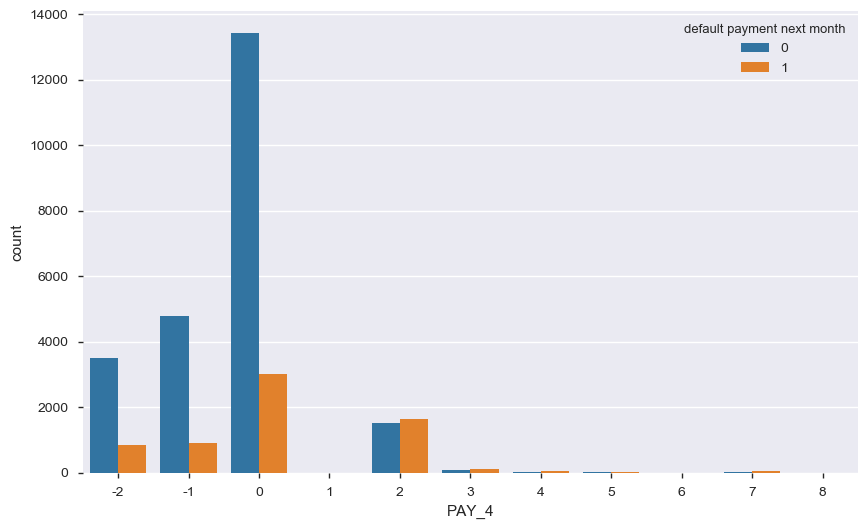

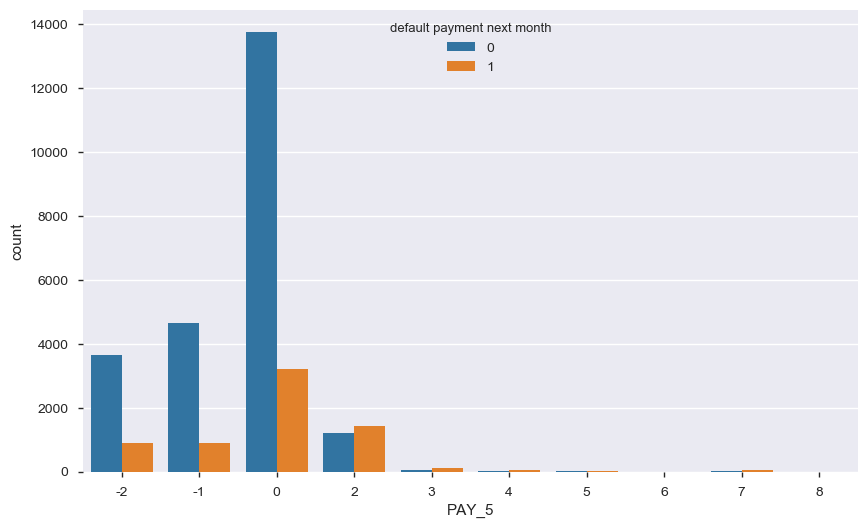

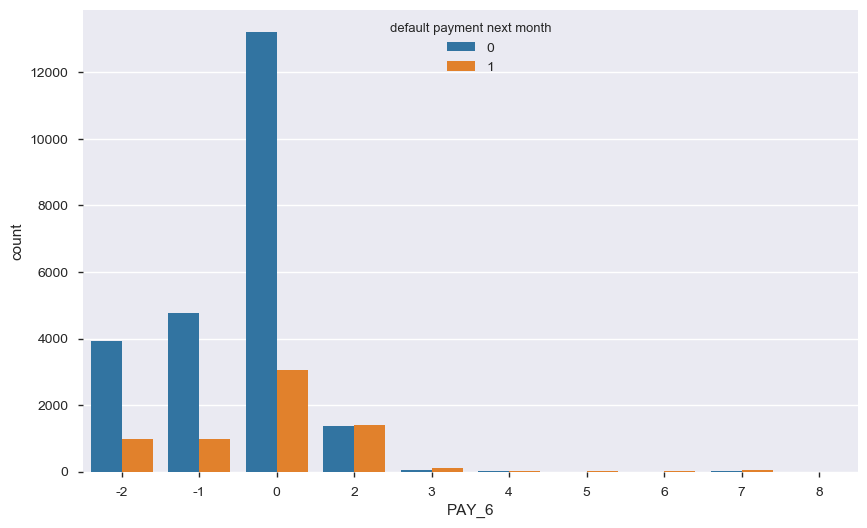

In [13]:
for c in all_data.columns[:11]:
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x = c, hue="default payment next month", data = all_data)

#### 3.2.5 Explore sum of pay status

Because the the encoding for payment status ranged from -2 to infinitive, and the less is the better. We can add up all the payment status and use the sum to plot a graph. We can divide the data into two groups which are "ltz": less than zero and "mtz":more than zero, and investigate the percentage of getting default next month in each group.

In [14]:
pay_status_sum = all_data.iloc[:, 5:11].sum(axis=1)
bill_sum = all_data.iloc[:, 11:17].sum(axis=1)
pay_sum = all_data.iloc[:, 17:23].sum(axis=1)

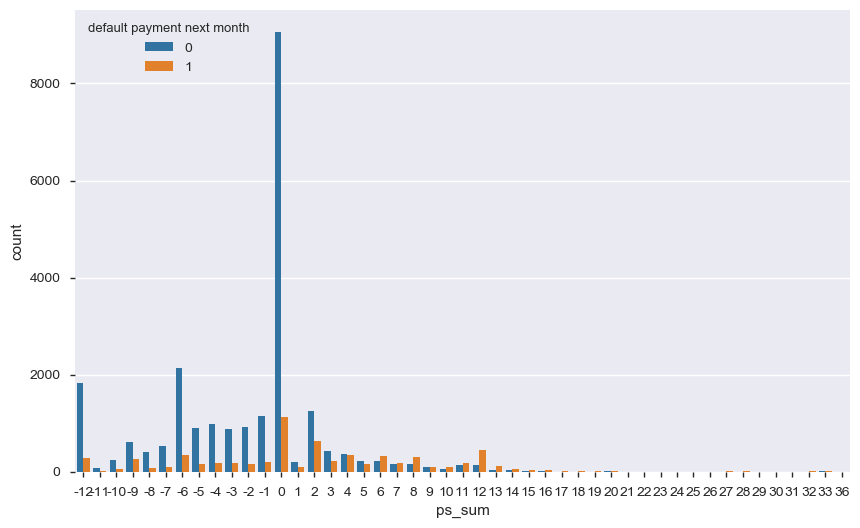

In [15]:
all_data["ps_sum"]  = pay_status_sum
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x = "ps_sum", hue="default payment next month", data = all_data)

In [16]:
ltz = all_data[all_data["ps_sum"]<=0]
mtz = all_data[all_data["ps_sum"]>0]
ltz_1 = ltz["default payment next month"][ltz["default payment next month"]==1].count()/len(ltz)
mtz_1 = mtz["default payment next month"][mtz["default payment next month"]==1].count()/len(mtz)

print("Percentage of individuals getting default with a sum of pay status <=0: {:.3f}%".format(ltz_1*100))
print("Percentage of individuals getting default with a sum of pay status >0: {:.3f}%".format(mtz_1*100))

Percentage of individuals getting default with a sum of pay status <=0: 13.815%
Percentage of individuals getting default with a sum of pay status >0: 48.745%


#### 3.2.6 Explore limit-bill

In [17]:
all_data["limit-bill"] = all_data['LIMIT_BAL']*6 - bill_sum

In [18]:
spent_less_than_limit = all_data[all_data["limit-bill"]>=0]
spent_more_than_limit= all_data[all_data["limit-bill"]<0]
sll_1 = spent_less_than_limit["default payment next month"][spent_less_than_limit["default payment next month"]==1].count()/len(spent_less_than_limit)
sml_1 = spent_more_than_limit["default payment next month"][spent_more_than_limit["default payment next month"]==1].count()/len(spent_more_than_limit)

print("Percentage of individuals getting default who spent less than the limit: {:.3f}%".format(sll_1*100))
print("Percentage of individuals getting default who spent more than the limit: {:.3f}%".format(sml_1*100))

Percentage of individuals getting default who spent less than the limit: 21.857%
Percentage of individuals getting default who spent more than the limit: 34.223%


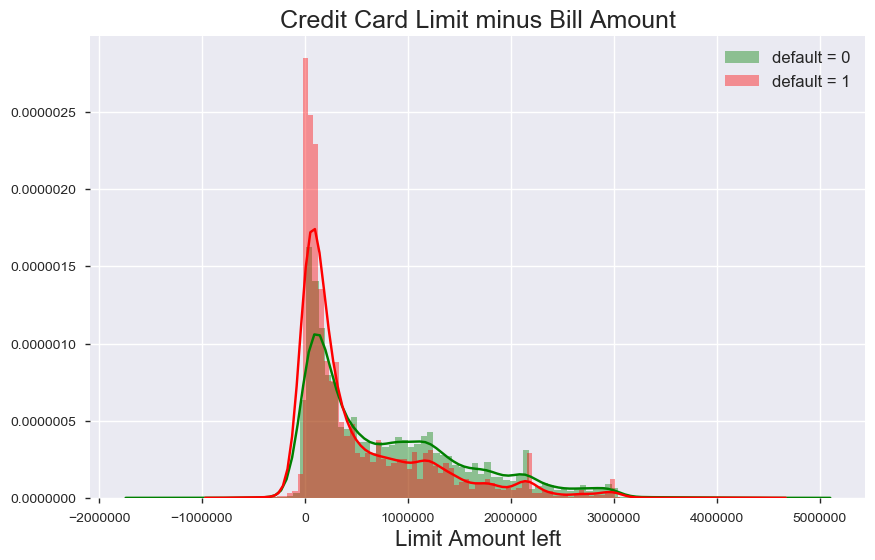

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(all_data["limit-bill"][all_data["default payment next month"]==0],color='green', bins=100,label = 'default = 0')
sns.distplot(all_data["limit-bill"][all_data["default payment next month"]==1],color='red', bins=100,label = 'default = 1')
plt.title('Credit Card Limit minus Bill Amount', fontsize=18)
plt.xlabel('Limit Amount left', fontsize=16)
plt.legend(prop={'size': 12})

#### 3.2.7 Explore Bill - Pay

In [20]:
# bill_sum.replace(0, 0.001, inplace = True) #so that the denominator won't be zero
all_data["bill-pay"] = bill_sum - pay_sum

In [21]:
paid_less_than_bill = all_data[all_data["bill-pay"]>0]
paid_more_than_bill = all_data[all_data["bill-pay"]<=0]
plb_1 = paid_less_than_bill["default payment next month"][paid_less_than_bill["default payment next month"]==1].count()/len(paid_less_than_bill)
pmb_1 = paid_more_than_bill["default payment next month"][paid_more_than_bill["default payment next month"]==1].count()/len(paid_more_than_bill)

print("Percentage of individuals getting default who paid less than the bill: {:.3f}%".format(plb_1*100))
print("Percentage of individuals getting default who paid more than the bill: {:.3f}%".format(pmb_1*100))

Percentage of individuals getting default who paid less than the bill: 22.472%
Percentage of individuals getting default who paid more than the bill: 20.178%


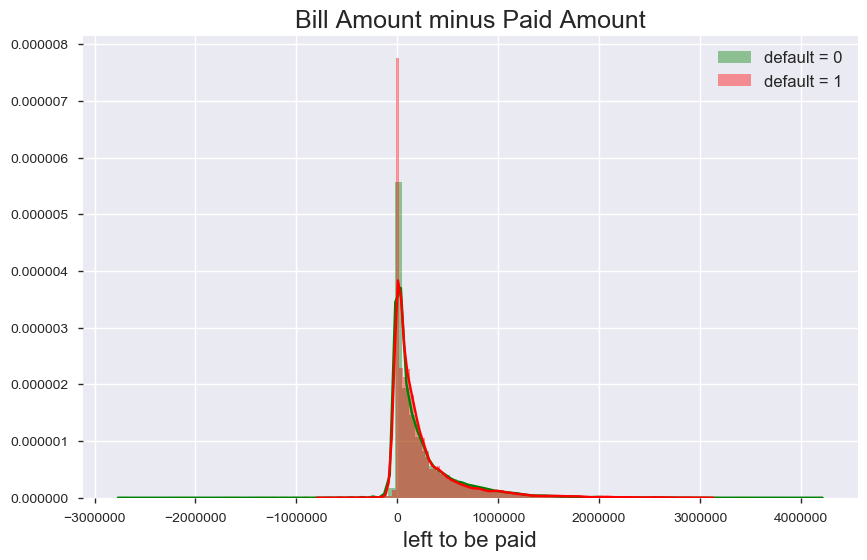

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(all_data["bill-pay"][all_data["default payment next month"]==0],color='green', bins=100,label = 'default = 0')
sns.distplot(all_data["bill-pay"][all_data["default payment next month"]==1],color='red', bins=100,label = 'default = 1')
plt.title('Bill Amount minus Paid Amount', fontsize=18)
plt.xlabel('left to be paid', fontsize=16)
plt.legend(prop={'size': 12})

In [23]:
# bills = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
#        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
#        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
# for c in bills:
#     fig, ax = plt.subplots(figsize=(10,6))
#     plt.title(c + " Distribution", fontsize=12)
#     plt.xlabel('Amount in Dollars', fontsize=10)
#     plt.ylabel('Frequency', fontsize=10)
#     n, bins, patches = plt.hist(x=all_data[c], bins='auto', color='#0504aa', rwidth=0.85)

From the above diagram, we can see that the data is highly skewed, transformation is necessary  before trainning so that the data do not negatively affect the performance of a learning algorithm. Later I will be using a cubic root transformation significantly to reduce the range of values caused by outliers.

### 3.2.8 Summary of EDA

1. Use auto-generated report to get an overview of the data

    1. what problems did we find
        1. From the ProfileReport we can know that this dataset is not balanced. I.e only 20% of the dataset have a default of 1.
        2. The BIll_AMT 2-6 are highly correlated with BILL_AMT1
        3. The PAY_AMT2 is highly skewed
 
    2. what we can do to resolve this 
        1. use resample method to create or reduce the number of data in the engineering step
        2. may remove these columns in the engineering step
        
2. Use boxplots to evaluate skewness and visualize outliners
    1. what problems did we find
        1. All the bill amts and pay amts feature are highly right-skewed.
        2. The range for these values are extremely large, If a feature has a variance that is too big, it may dominate the objective function and make the model unable to learn from other features correctly as expected. 
        
    2. what we can do to resolve this 
        1. use cubic transformation to do normalisation in the engineering step
        2. use minmaxscal() function to scale the range in the engineering step
        
3. Use describe() to retrive the gereral statistics for each feature
    1. Nothing special was found
    
4. Use countplot() to visualise the distribution of all the categorical features
    *********fill this in**********
5. Explore sum of pay status 
    *********fill this in**********
6. Explore limit - bill
    *********fill this in**********
7. Explore Bill - Paid
    *********fill this in**********

5,6,7 are new features we constructed ourself, we added this feature to help the mining process. We are hoping to find a new feature which can be used to separate the default and non-default group Significantly for.

use this source and your own findings to fill this part in 
https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5

# 4. Methodology Overview

1. overview
2. Data Engineering
3. Training and Evaluating Model

#### 4.1 Overview



#### 4.2 Data Engineering
#### 4.2.1 Use the “rule of thumb” to remove outliners

reference: http://myweb.sabanciuniv.edu/rdehkharghani/files/2016/02/The-Morgan-Kaufmann-Series-in-Data-Management-Systems-Jiawei-Han-Micheline-Kamber-Jian-Pei-Data-Mining.-Concepts-and-Techniques-3rd-Edition-Morgan-Kaufmann-2011.pdf

In [24]:
#new Q1 = Q1 - 1.5*IQR
#new Q3 = Q3 + 1.5*IQR
quertiles = pd.DataFrame(Q1)
quertiles["Q3"] = Q3
quertiles.columns = ["Q1","Q3"]
quertiles["IQR"] = quertiles["Q3"] - quertiles["Q1"]
quertiles["newQ1"] = quertiles["Q1"] -1.5*quertiles["IQR"]
quertiles["newQ3"] = quertiles["Q3"] +1.5*quertiles["IQR"]
quertiles

,Q1,Q3,IQR,newQ1,newQ3
LIMIT_BAL,50000.00,240000.00,190000.00,-235000.000,525000.000
SEX,0.00,1.00,1.00,-1.500,2.500
EDUCATION,1.00,2.00,1.00,-0.500,3.500
MARRIAGE,1.00,2.00,1.00,-0.500,3.500
AGE,28.00,41.00,13.00,8.500,60.500
BILL_AMT1,3558.75,67091.00,63532.25,-91739.625,162389.375
BILL_AMT2,2984.75,64006.25,61021.50,-88547.500,155538.500
BILL_AMT3,2666.25,60164.75,57498.50,-83581.500,146412.500
BILL_AMT4,2326.75,54506.00,52179.25,-75942.125,132774.875
BILL_AMT5,1763.00,50190.50,48427.50,-70878.250,122831.750


In [25]:
# remove outliners in LIMIT_BAL

all_data['LIMIT_BAL'][all_data['LIMIT_BAL']>750000] = np.nan

# remove outliners in BILL AMTs
for c in ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']:
    all_data[c][all_data[c] < quertiles.loc[c]["newQ1"]] = np.nan
    all_data[c][all_data[c]>(quertiles.loc[c]["newQ3"] +220000)] = np.nan

# remove outliners in PAY AMTs
for c in ['PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    all_data[c][all_data[c]>(quertiles.loc[c]["newQ3"] +200000)] = np.nan

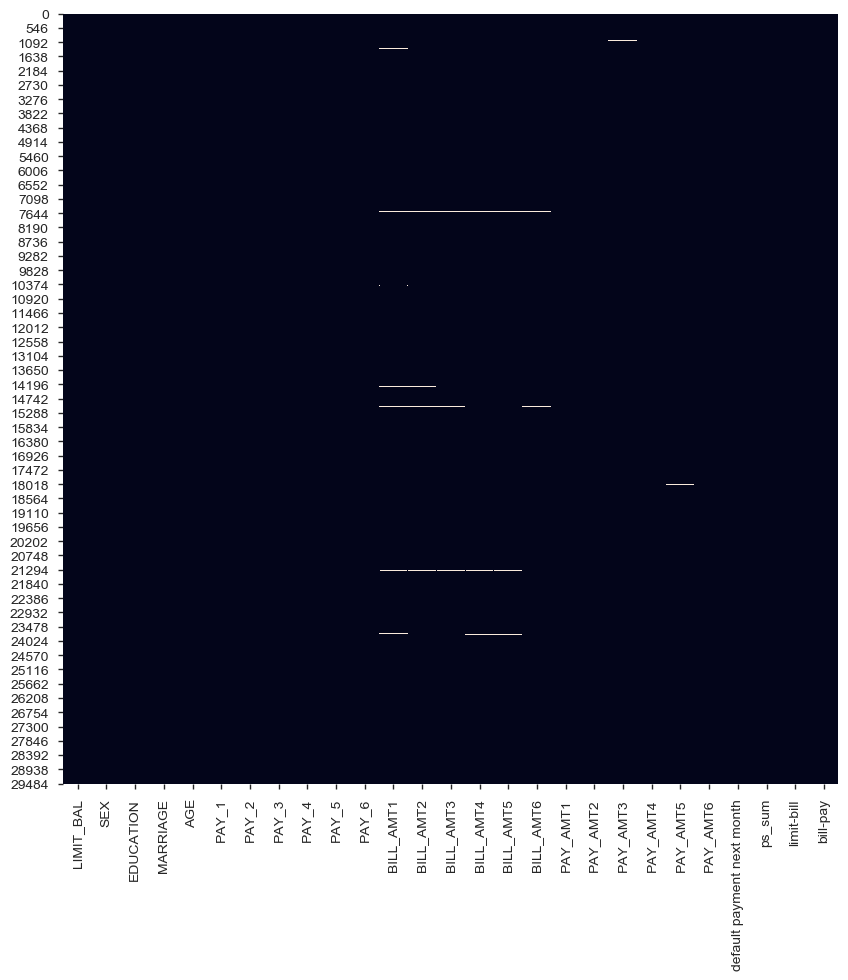

In [26]:
# Investigate patterns in the amount of missing data in each column.
plt.subplots(figsize=(10,10))
sns.heatmap(all_data.isnull(), cbar=False)

In [27]:
# only use the rows with no null values
all_zero_nan = all_data[all_data.isnull().sum(axis=1) == 0]

#### 4.2.2 Binning the AGE features (Discretization)

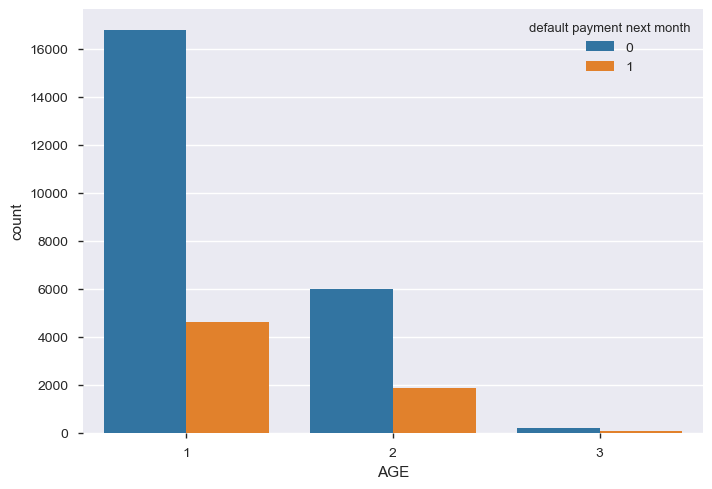

In [28]:
# binning the AGE feature which ranges from 21 to 79
bins = [20,40,60,80]
labels = [1,2,3]
all_zero_nan['AGE'] = pd.cut(all_zero_nan['AGE'], bins, labels=labels)

sns.countplot(x = 'AGE', hue="default payment next month", data = all_zero_nan)

#### 4.2.3 Normalisation and Scaling

In [29]:
# create an engineering function to do normalisation and scaling
def engineer(data):
    
    train = data
    
    #Normalise the range
    bills = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    features_cubic_transformed = train
    features_cubic_transformed[bills] = train[bills].apply(lambda x: np.sign(x) * np.power(abs(x), 1./3))

    ##display normalised data
#     for c in bills:
#         fig, ax = plt.subplots(figsize=(10,6))
#         plt.title("Nomalised " + c)
#         n, bins, patches = plt.hist(x=features_cubic_transformed[c], bins='auto', color='#0504aa')
    
    # scale all numerical data
    numerical = ['LIMIT_BAL','PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    scaler = MinMaxScaler()
    features_cubic_transformed[numerical] = scaler.fit_transform(features_cubic_transformed[numerical])
    

    final = pd.get_dummies(features_cubic_transformed, columns = ["EDUCATION","MARRIAGE","AGE"])
    
    return final

In [30]:
# clean the data
engineered_data = engineer(all_zero_nan)

In [31]:
# pandas_profiling.ProfileReport(engineered_data)

#### 4.2.4 split train and test data

In [32]:
#save the label to anotehr dataframe
Y = engineered_data['default payment next month']
X = engineered_data
X.drop('default payment next month', axis = 1,inplace = True)

In [33]:
# Split the 'features' and 'income' data into training and testing sets
train_x, test_x, train_y, test_y= train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 41)

# Show the results of the split
print("Training set has {} samples.".format(train_x.shape[0]))
print("Testing set has {} samples.".format(test_x.shape[0]))

Training set has 23634 samples.
Testing set has 5909 samples.


In [34]:
# split the original train test data to create a base model
otrain_y = df_train['default payment next month']
otrain_x = df_train
otrain_x.drop('default payment next month', axis = 1,inplace = True)
otrain_x.drop('ID', axis = 1,inplace = True)
otest_y = df_test['default payment next month']
otest_x = df_test
otest_x.drop('default payment next month', axis = 1,inplace = True)
otest_x.drop('ID', axis = 1,inplace = True)

#### 4.2.5 Create a base model

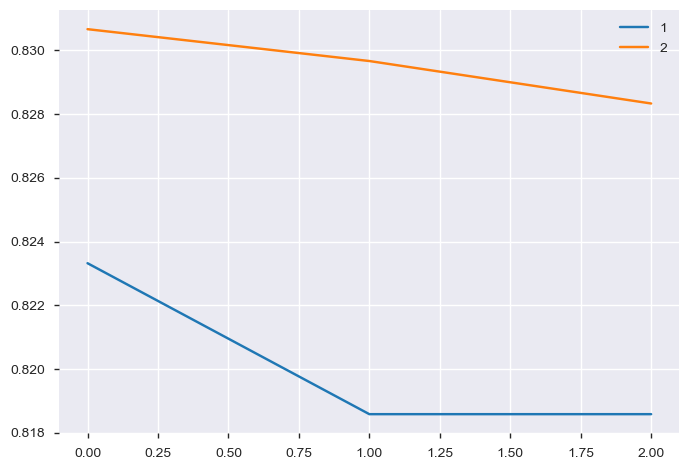

In [35]:
#test accuracy against the original data

first = []
second = []
for n in [1,10,100]:
    #clf1 uses engineered data
    clf1 = AdaBoostClassifier(random_state=41,n_estimators = n)
    clf1.fit(train_x,train_y)
    accuracy1 = clf1.score(test_x,test_y)
    first.append(accuracy1)
    
    #clf2 uses original data
    clf2 = AdaBoostClassifier(random_state=41,n_estimators = n)
    clf2.fit(otrain_x,otrain_y)
    accuracy2 = clf2.score(otest_x,otest_y)
    second.append(accuracy2)

plt.plot(first,label = 1)
plt.plot(second,label = 2)
plt.legend()

#### 4.2.6 visualise feature importance and reduce dimension

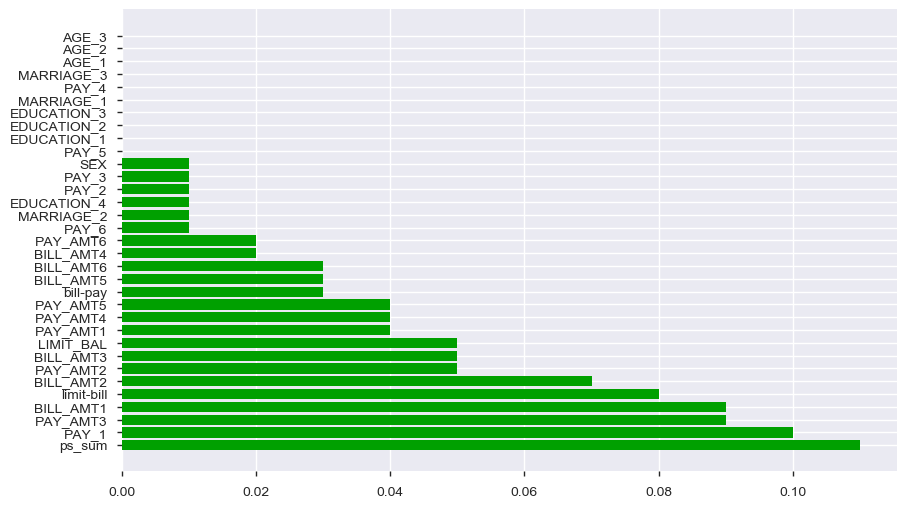

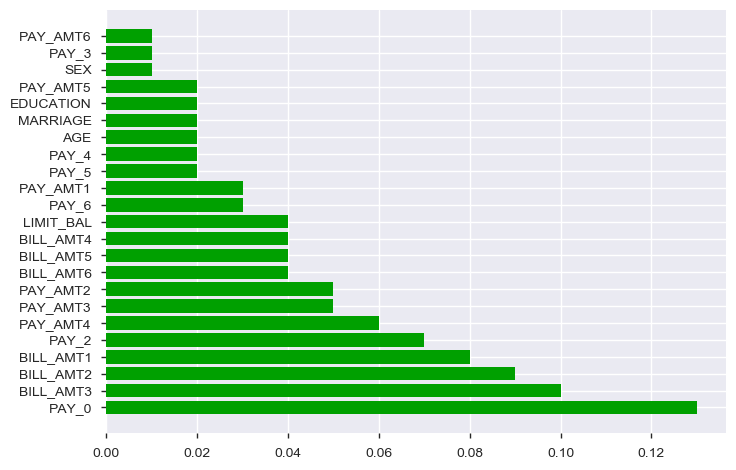

In [36]:
# Compare the importance
i1 = clf1.feature_importances_
i1_df= pd.DataFrame(i1.tolist(), index = train_x.columns)
i1_df.columns = ["clf1"]
i1_df = i1_df.sort_values(by = "clf1",ascending = False)

i2 = clf2.feature_importances_
i2_df= pd.DataFrame(i2.tolist(), index = otrain_x.columns)
i2_df.columns = ["clf2"]
i2_df = i2_df.sort_values(by = "clf2",ascending = False)

fig, ax = plt.subplots(figsize=(10,6))
plt.barh(i1_df.index, i1_df["clf1"],align="center", color = '#00A000',label = "Feature Weight")
# plt.barh(i1_df.index, np.cumsum(i1_df["clf1"]),align = "center", color = '#00A0A0',label = "Cumulative Feature Weight")
plt.show()
plt.barh(i2_df.index, i2_df["clf2"],align="center", color = '#00A000',label = "Feature Weight")
plt.show()

In [37]:
# drop the features which are extremely weak correlated and have very little weight after training
# to_drop = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
# train_x.drop(to_drop, axis = 1,inplace = True)
# test_x.drop(to_drop, axis = 1,inplace = True)

#### 4.2.7 resampling to solve imbalances

In [38]:
#Split the training 24000 data sets into training and testing sets, 
#so can test on them by different sampling methods and classifiers, also the performance of our final model.
default_train_x, default_test_x, default_train_y, default_test_y= train_test_split(train_x, train_y, test_size = 0.2, random_state = 41)

In [39]:
dfForSampling = pd.concat([pd.DataFrame(default_train_x),pd.DataFrame(default_train_y)],axis = 1)
df_default_people = dfForSampling.loc[dfForSampling['default payment next month'] == 1]
df_non_default_people = dfForSampling.loc[dfForSampling['default payment next month'] == 0]


print("-"*50)
print('The number of people default')
print(df_default_people['default payment next month'].count())
print("-"*50)
print('The number of people non-default')
print(df_non_default_people['default payment next month'].count())
print("-"*50)

--------------------------------------------------
The number of people default
4212
--------------------------------------------------
The number of people non-default
14695
--------------------------------------------------


+ According to the findings above, the default and non-default sets are unbalanced, we have more non-default than default.
+ It is not huge unbalance, but it is good to thinkg about how to balance the data in a better performance. 
+ here are three ways(algorithms) to do with the sampling, e.g. simpling copy and cuts, SMOTE and ADASYN(an improvement on SMOTE). 
+ Let's see the differences and work can do with this balance work.

Also, we are using balanced data in two ways in this projects, the first appearance is at section 5.2 to see different classifiers under unbalanced and SMOTE balanced algorithms. The second place is before the final prediction to choose the best data sets to fit with our final model.

#### 4.2.7.1 resample method

In [40]:
# upscales the default samples to the same size as non default
df_default_upscaled = resample(df_default_people, replace=True, n_samples=14695, random_state=100)
# Combine the non-default and upscaled default
df_upscaled = pd.concat([df_non_default_people, df_default_upscaled])

df_upscaled['default payment next month'].value_counts()

1    14695
0    14695
Name: default payment next month, dtype: int64

In [41]:
# downscales the non-default samples to the same size as default
df_non_default_downscaled = resample(df_non_default_people, replace=True, n_samples=4212, random_state=100)
# Combine the default and downscaled non-default
df_downscaled = pd.concat([df_default_people, df_non_default_downscaled])

df_downscaled['default payment next month'].value_counts()

1    4212
0    4212
Name: default payment next month, dtype: int64

There are two big issues with resampling according to the paper and documntation of sklearn.utils.resample we read.
+ 1. The upscaled default will brings overfitting since the sklearn.utils.resample() just copy and paste the old datas, it brings huge redundant and overfitting warnings in the data mining.
+ 2. The downscaled non-default will cause loss in data and so the biases, since it simply cut-off some of useful data.
Let us see what we can do with SMOTE to avoid these problems.

#### 4.2.7.2 SMOTE

In [42]:
#SMOTE adopts the 'not. majority' as default sampling strategy, we just rewrite here to annouce that we are only doing
#upscaled but not downscaled so choosing 'not majority' to avoid unbias.
sm = SMOTE(sampling_strategy='not majority',random_state=100)
X_SMOTE, y_SMOTE = sm.fit_sample(default_train_x, default_train_y)
print(len(X_SMOTE))
print(y_SMOTE.sum())

29390
14695


According to the paper by Akanksha, Synthetic Minority(SMOTE) oversampling approach is an oversampling approach in which rather than replacing the existing samples here new samples are synthetically generated.

+ 1.Find the k-nearest neighbors for our minority class instance Y by applying Euclidean distance to find the distance between the instance Y and others in the same class.
+ 2.Based on the sampling ratio, an instance among k-nearest neighbors is randomly selected.
+ 3.The new synthetic data is created by taking the difference between chosen k-nearest neighbor and current data

#### 4.7.2.3 ADASYN

In [43]:
ada = ADASYN(random_state=100)
X_ADA, y_ADA = ada.fit_sample(default_train_x, default_train_y)
print(len(X_ADA))
print(y_ADA.sum())

29042
14347


Adaptive synthetic is an repacement to the SMOTE, it does  not simply upscale or down scale the minority or majority but decides on the weighting.
According to the paper by Akanksha, 'The difference between Smote and ADASYN is that ...the ADASYN algorithm makes use of density function which decides how many number of synthetic data has to be generated for every minority instance.'

# 5. Model Training & Validation
This contains a breakdown of how your model was trained and evaluated.


### 5.1 Using K-fold cross validation to test the performance of different ensemble classifiers
Here we are using the clean data sets after transformation and feature engineering has been applied, and then feeds into different classifiers to test the performance. We are using runtime, accuracy, fbeta(beta=3) for analysis on the performance.

In [44]:
# set the list of potential classifiers
clf_list = [
            #averaging
            DecisionTreeClassifier(max_depth = 4, min_samples_split = 2,random_state = 100),
            RandomForestClassifier(n_estimators = 60, random_state = 100),
            BaggingClassifier(random_state = 100),
            #boosting
            AdaBoostClassifier(n_estimators = 60, random_state = 100),
            GradientBoostingClassifier(),
            #others
            KNeighborsClassifier(),
            LogisticRegression(random_state=100),
            GaussianNB()
]

# clf_list = [
#             AdaBoostClassifier(n_estimators = 60, random_state = 100),
#             LogisticRegression(random_state=100),
#             GaussianNB()
# ]

According to the paper we read, we think it is better to enhance recall since we want more default people can be caught out other than less non-default by wrongly caught out. The reason we used fbeta(beta=3) is that, fbeta(beta=3) considers more recall than precision from the documentation of sklearn.metrics.fbeta_score.

In [45]:
# split the data sets into 6 folders to multple trains and tests
kf = KFold(n_splits=6,random_state=100,shuffle=True)

#create the lists of performance of each classifiers
mdl = []
fold = []
accuracy = []
fbeta = []
timeLength = []

#dfForSampling is defined above as  default_train_x.join(default_train_y), 
#dfForSampling it is the train sets for oversampling and model selection
for i,(train_index, test_index) in enumerate(kf.split(dfForSampling)):
    
    training = dfForSampling.iloc[train_index,:]
    test = dfForSampling.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training.drop('default payment next month', axis = 1,inplace = False)
        label = training['default payment next month']
        valid_feats = test.drop('default payment next month', axis = 1,inplace = False)
        valid_label = test['default payment next month']
        start = time()
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        end = time()
        
        accuracyScore = accuracy_score(y_true = valid_label, y_pred = pred)
        fbetaScore= fbeta_score(y_true = valid_label, y_pred = pred, beta = 3)
        
        fold.append(i+1)
        accuracy.append(accuracyScore)
        fbeta.append(fbetaScore)
        timeLength.append(end-start)
        mdl.append(model)
        print(model)


performance = pd.DataFrame({'Model': mdl, 'Accuracy':accuracy, 'Fbeta': fbeta, 'Runtime': timeLength, 'Fold':fold})

0
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
1
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
2
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
3
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
4
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
5
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB


In [46]:
# ROC = roc_auc_score(y_true = valid_label, y_scores = pred)

In [47]:
#performance_a[performance_a['Model'] == 'AdaBoostClassifier']['Score'].mean()

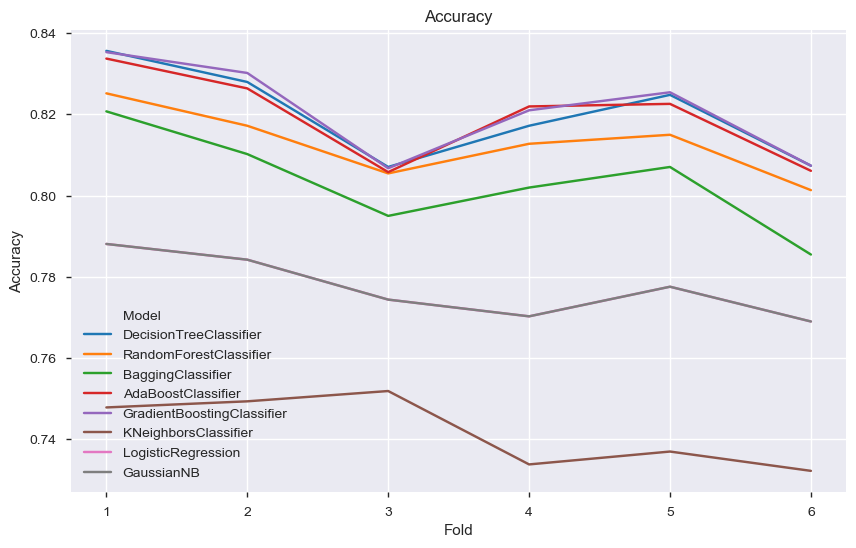

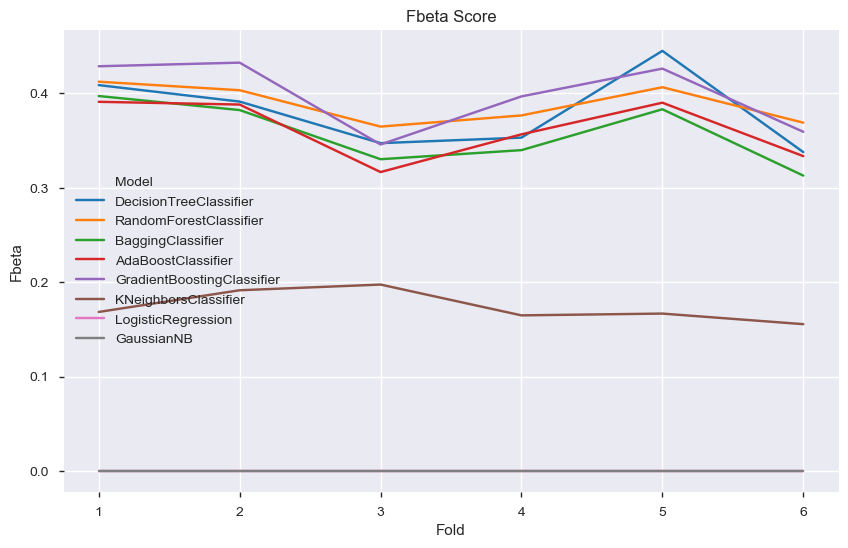

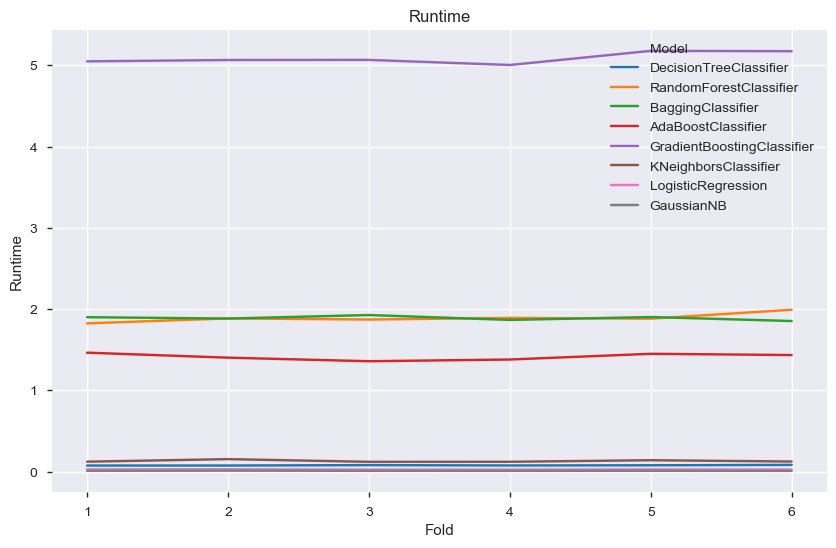

In [48]:
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Accuracy",hue = "Model" ,data=performance).set_title("Accuracy")
plt.show()
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Fbeta",hue = "Model" ,data=performance).set_title("Fbeta Score")
plt.show()
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Runtime",hue = "Model" ,data=performance).set_title("Runtime")
plt.show()

In [49]:
# Use the oversample(balanced) data to see if any improvements on it
SMOTE_sampling = pd.concat([pd.DataFrame(X_SMOTE),pd.DataFrame(y_SMOTE)],axis = 1)

#create the lists of performance of each classifiers
mdl = []
fold = []
accuracy = []
fbeta = []
timeLength = []

for i,(train_index, test_index) in enumerate(kf.split(SMOTE_sampling)):
    
    training = SMOTE_sampling.iloc[train_index,:]
    test = SMOTE_sampling.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training.drop('default payment next month', axis = 1,inplace = False)
        label = training['default payment next month']
        valid_feats = test.drop('default payment next month', axis = 1,inplace = False)
        valid_label = test['default payment next month']
        start = time()
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        end = time()
        
        accuracyScore = accuracy_score(y_true = valid_label, y_pred = pred)
        fbetaScore= fbeta_score(y_true = valid_label, y_pred = pred, beta = 3)
        
        fold.append(i+1)
        accuracy.append(accuracyScore)
        fbeta.append(fbetaScore)
        timeLength.append(end-start)
        mdl.append(model)
        print(model)


SMOTE_performance = pd.DataFrame({'Model': mdl, 'Accuracy':accuracy, 'Fbeta': fbeta, 'Runtime': timeLength, 'Fold':fold})

0
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
1
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
2
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
3
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
4
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
5
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB


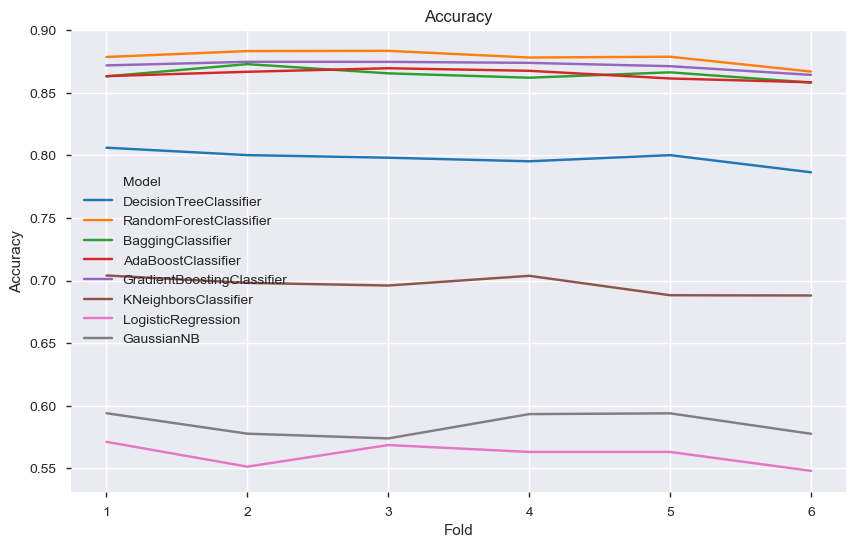

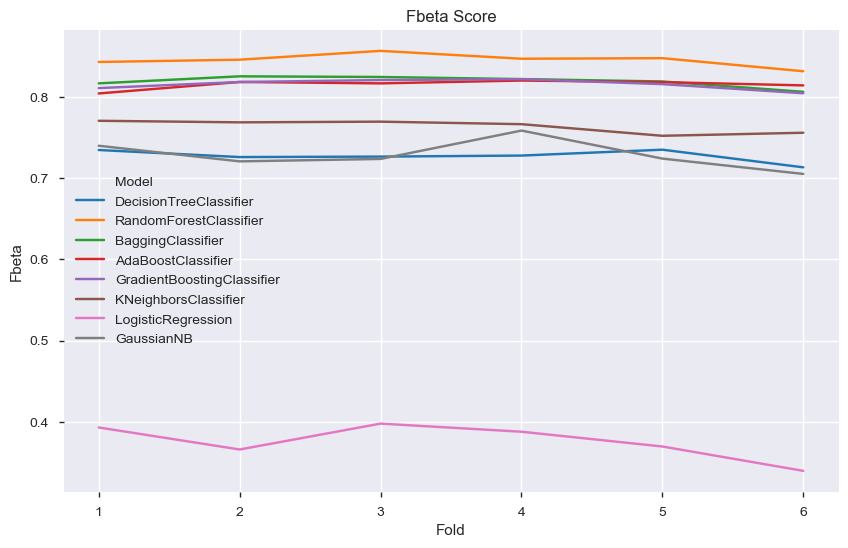

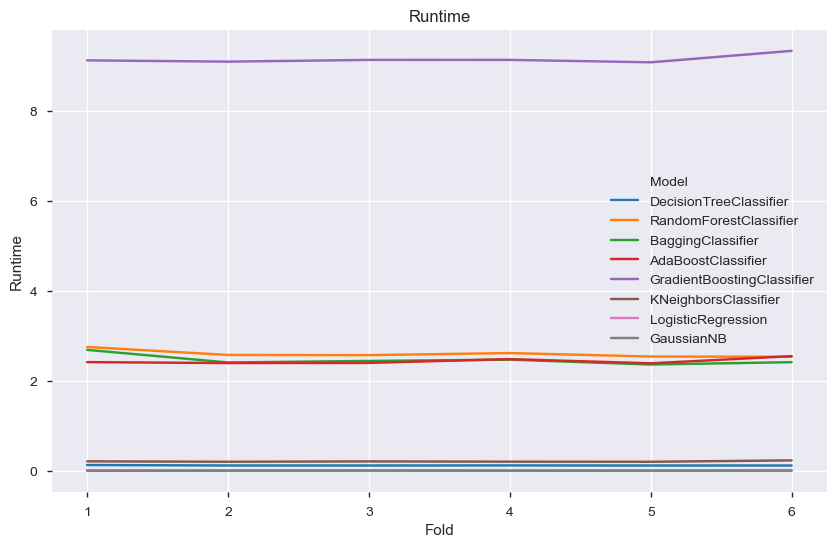

In [50]:
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Accuracy",hue = "Model" ,data=SMOTE_performance).set_title("Accuracy")
plt.show()
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Fbeta",hue = "Model" ,data=SMOTE_performance).set_title("Fbeta Score")
plt.show()
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Runtime",hue = "Model" ,data=SMOTE_performance).set_title("Runtime")
plt.show()

+ There is huge changes in differences in accuracy and fbeta score.
+ The reason are explained in details in report, but we can see that the classifiers are getting closer and hard to see the differences. 

In [51]:
# # plot the confision matrix and precision_recall_curve
# cm = ConfusionMatrix(test_y.tolist(), predictions.tolist())
# print("Confusion matrix:\n%s" % cm)
# cm.plot()
# cm.stats()# to retrieve the dictionary 
# print("-"*30)
# show_metrics()
# score_y = clf.decision_function(test_x)
# precision, recall, thresholds = precision_recall_curve(test_y, score_y)
# fig, ax = plt.subplots(figsize=(10,6))
# plot_precision_recall()

According to the findings above, we decides to use Adaboosting, RandomForestsClassifier, GaussianNB and LogisticRegression. The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

### 5.2 GridSearch CV for tuning

So first of all let's find the best hyperparameters of the classifiers. Due to the limits on the computation, we can only do a little cross-validation which means not very deep and large param_grid but still can make little differences that can prove our guess.

### 5.2.1 AdaBoostClassifier

In [52]:
# define the classifier.
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
# training the classifier
clf.fit(default_train_x, default_train_y)
# do our predictions on the test
predictions = clf.predict(default_test_x)
# see how good it is on default
accuracy_score(y_true = default_test_y, y_pred = predictions)

0.807911994922784

The score is not too bad as expected, let's how about feed in the best hyperparameters gained by cross-validation in grid(GridSearchCV).

In [53]:
param_grid = {'n_estimators': [1,10,40],
              'algorithm': ['SAMME','SAMME.R'],
              'learning_rate' : [0.01, 0.3, 0.9]}
grid_search_tree = GridSearchCV(AdaBoostClassifier(), param_grid, cv = 5, scoring= 'accuracy')

#training
grid_search_tree.fit(default_train_x, default_train_y)
#let's see the best estimator
print(grid_search_tree.best_estimator_)
#with its score
print(np.abs(grid_search_tree.best_score_))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=40, random_state=None)
0.8203309821953431


Let's see the classifier with predicted best hyperparamers gained by cross-validation through GridSearchCV

In [54]:
classifier = AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.3,
                   n_estimators=40, random_state=None)
classifier.fit(default_train_x, default_train_y)
predictions = classifier.predict(default_test_x)
accuracy_score(y_true = default_test_y, y_pred = predictions)

0.8085466469219378

There is no big benefits to use oversampling or downsampling here, the reason is that 
+ we will do voting as the last steps to combine all the classifiers we are happy with.
+ due to the limits on the computation, we can only do a little cross-validation as seen above, there will not be much differences on hyperparameters.

### 5.2.2.RandomForestsClassifier

In [55]:
clf = RandomForestClassifier(n_estimators=100, )
clf.fit(default_train_x, default_train_y)
predictions = clf.predict(default_test_x)
accuracy_score(y_true = default_test_y, y_pred = predictions)

0.813200761582399

In [56]:
param_grid = {'n_estimators': [50, 100],
              'criterion': ['entropy', 'gini'],
             }

grid_search_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring= 'accuracy')

#training
grid_search_tree.fit(default_train_x, default_train_y)
#let's see the best estimator
print(grid_search_tree.best_estimator_)
#with its score
print(np.abs(grid_search_tree.best_score_))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.8149891515525246


In [57]:
classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
classifier.fit(default_train_x, default_train_y)
predictions = classifier.predict(default_test_x)
accuracy_score(y_true = default_test_y, y_pred = predictions)

0.813200761582399

There's no big differences as expected. However, we can still expect that for larger grird search by powerful computer, there will be a better hyperparameter to increase the accuracy. The reason for that is the cross-validation is still too small, it brings underfit to the data, so the clf is unstable and always makes wrong.

In [58]:
# def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix"', cmap = plt.cm.Blues) :
#     plt.figure()
#     plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation = 0)
#     plt.yticks(tick_marks, classes)
 
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment = 'center',
#                  color = 'white' if cm[i, j] > thresh else 'black')
 
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()
    
# def show_metrics():
#     tp = cm.stats()['TP']
#     fn = cm.stats()['FN']
#     fp = cm.stats()['FP']
#     tn = cm.stats()['TN']
#     print('Precision: {:.3f}'.format(tp/(tp+fp)))
#     print('Recall: {:.3f}'.format(tp/(tp+fn)))
#     print('F1 score: {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))))

    
# def plot_precision_recall():
#     plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
#     plt.fill_between(recall, precision, step ='post', alpha = 0.2, color = 'b')
#     plt.plot(recall, precision, linewidth=2)
#     plt.xlim([0.0,1])
#     plt.ylim([0.0,1.05])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision Recall Curve')
#     plt.show();

# plot the confision matrix and precision_recall_curve
# cm = ConfusionMatrix(test_y.tolist(), predictions.tolist())
# print("Confusion matrix:\n%s" % cm)
# cm.plot()
# cm.stats()# to retrieve the dictionary 
# print("-"*30)
# show_metrics()
# score_y = clf.decision_function(test_x)
# precision, recall, thresholds = precision_recall_curve(test_y, score_y)
# fig, ax = plt.subplots(figsize=(10,6))
# plot_precision_recall()

## 5.3 Final Voting Classifiers on choosen classifiers
The last step is to use the voting algorithm to 

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

In [82]:
# default_train_x, default_test_x, default_train_y
clf1 = AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.3,
                   n_estimators=40, random_state=None)

clf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf3 = LogisticRegression(random_state=100)

clf4 = GaussianNB()

eclf1 = VotingClassifier(estimators=[('Ada', clf1), ('Rf', clf2), ('Lr', clf3), ('GNB', clf4)], voting='hard')
eclf1 = eclf1.fit(default_train_x, default_train_y)
predictions = eclf1.predict(default_test_x)
print('-'*60)
print('accuracy score of the final ensemble classifiers under unbalanced sample is ')
print(accuracy_score(y_true = default_test_y, y_pred = predictions))
print('fbeta score of the final ensemble classifiers under unbalanced sample is ')
print(fbeta_score(y_true = default_test_y, y_pred = predictions, beta = 3))
print('-'*60)

------------------------------------------------------------
accuracy score of the final ensemble classifiers under unbalanced sample is 
0.7761793949650941
fbeta score of the final ensemble classifiers under unbalanced sample is 
0.0
------------------------------------------------------------


In [77]:
len(default_test_x), len(default_test_y)

(4727, 4727)

In [83]:
eclf2 = VotingClassifier(estimators=[('Ada', clf1), ('Rf', clf2), ('Lr', clf3), ('GNB', clf4)], voting='hard')
eclf2 = eclf2.fit(X_SMOTE, y_SMOTE)
predictions = eclf2.predict(default_test_x)
print('-'*60)
print('accuracy score of the final ensemble classifiers under SMOTE balanced sample is ')
print(accuracy_score(y_true = default_test_y, y_pred = predictions))
print('fbeta score of the final ensemble classifiers under SMOTE balanced sample is ')
print(fbeta_score(y_true = default_test_y, y_pred = predictions, beta = 3))
print('-'*60)

------------------------------------------------------------
accuracy score of the final ensemble classifiers under SMOTE balanced sample is 
0.8019885762640152
fbeta score of the final ensemble classifiers under SMOTE balanced sample is 
0.3885400313971743
------------------------------------------------------------


In [84]:
eclf3 = VotingClassifier(estimators=[('Ada', clf1), ('Rf', clf2), ('Lr', clf3), ('GNB', clf4)], voting='hard')
eclf3 = eclf3.fit(X_ADA, y_ADA)
predictions = eclf3.predict(default_test_x)
print('-'*60)
print('accuracy score of the final ensemble classifiers under ADASYN balanced sample is ')
print(accuracy_score(y_true = default_test_y, y_pred = predictions))
print('fbeta score of the final ensemble classifiers under ADASYN balanced sample is ')
print(fbeta_score(y_true = default_test_y, y_pred = predictions, beta = 3))
print('-'*60)

------------------------------------------------------------
accuracy score of the final ensemble classifiers under ADASYN balanced sample is 
0.8022001269303999
fbeta score of the final ensemble classifiers under ADASYN balanced sample is 
0.395806799255413
------------------------------------------------------------


In [ ]:
There is no big differences between results from SMOTE balanced data and SMOTE balanced data, but they improve significantly on
the raw unbalanced data, so we decided to use SMOTE algorithm, the eclf2.

#  6. Results

In [85]:
predictions = eclf2.predict(test_x)
print('-'*60)
print('accuracy score of the final ensemble classifiers under ADASYN balanced sample is ')
print(accuracy_score(y_true = test_y, y_pred = predictions))
print('fbeta score of the final ensemble classifiers under ADASYN balanced sample is ')
print(fbeta_score(y_true = test_y, y_pred = predictions, beta = 3))
print('-'*60)

------------------------------------------------------------
accuracy score of the final ensemble classifiers under ADASYN balanced sample is 
0.8084278219664918
fbeta score of the final ensemble classifiers under ADASYN balanced sample is 
0.3982157339821573
------------------------------------------------------------


# 7. Results

Here you show the results that you obtain using your model on the training data. If you have multiple variations or approaches, this is where you compare them.


# 8. Final predictions

This is the section where you perform your final predictions on the test set using the model that you have trained in the previous section.


# 9. References

https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5